In [1]:
with open("requirements.txt", "r") as config_file:
    config_code = config_file.read()
    exec(config_code)
%load_ext autoreload
%autoreload 2

### Data

In [96]:
tidy_finance = sqlite3.connect(database="data/specialedata.sqlite")

macro_predictors = (pd.read_sql_query(
    sql="SELECT * FROM macro_predictors",
    con=tidy_finance,
    parse_dates={"month"})
 .add_prefix("macro_")
)

JKPFactors = (pd.read_sql_query(
  sql="SELECT * FROM JKPFactors",
  con=tidy_finance,
  parse_dates={"month"})
  .add_prefix("jkp_factor_")
)
JKPFactornames = JKPFactors.columns

factors_ff3_monthly = (pd.read_sql_query(
     sql="SELECT * FROM factors_ff3_monthly",
     con=tidy_finance,
     parse_dates={"month"})
  .add_prefix("factor_ff3_")
)

factors_ff5_monthly = (pd.read_sql_query(
     sql="SELECT * FROM factors_ff5_monthly",
     con=tidy_finance,
     parse_dates={"month"})
  .add_prefix("factor_ff5_")
)

crsp_1000 = (pd.read_sql_query(
    sql="SELECT * FROM crsp_1000",
    con=tidy_finance,
    parse_dates={"month"})
)
crsp_500 = (pd.read_sql_query(
    sql="SELECT * FROM crsp_500",
    con=tidy_finance,
    parse_dates={"month"})
)
crsp_250 = (pd.read_sql_query(
    sql="SELECT * FROM crsp_250",
    con=tidy_finance,
    parse_dates={"month"})
)

crsp_100 = (pd.read_sql_query(
    sql="SELECT * FROM crsp_100",
    con=tidy_finance,
    parse_dates={"month"})
)

crsp_50 = (pd.read_sql_query(
    sql="SELECT * FROM crsp_50",
    con=tidy_finance,
    parse_dates={"month"})
)

# Select amount of tickers in cross section!
data_total = (crsp_50
        .merge(JKPFactors,
               how = "left", left_on = "month", right_on = "jkp_factor_month")
        .merge(macro_predictors,
             how = "left", left_on = "month", right_on = "macro_month")
        .merge(factors_ff5_monthly,
               how = "left", left_on = "month", right_on = "factor_ff5_month")
        .assign(ret_excess=lambda x: x["ret"] - x["macro_lty"]) 
        .drop(columns=['ret', 'jkp_factor_month', 'macro_month', 'factor_ff5_month'])
        .dropna()
       )

# Make a dataframe for stock characteristics and factors
macro_variables = data_total.filter(like="macro").columns
factor_variables = data_total.filter(like="jkp_factor").columns
macro_factors = data_total[macro_variables]
factors = data_total[macro_variables].merge(data_total[factor_variables], left_index=True, right_index=True)
char = data_total[['mktcap', 'mktcap_lag_1', 'mktcap_lag_3', 'mktcap_lag_6', 'mktcap_lag_12', 'mom_1', 'mom_3','mom_6', 'mom_12']]
# List of tickers
tickers = data_total['ticker'].unique()

# Transform data
column_combinations = list(product(macro_factors, char)) 

new_column_values = []
for macro_column, char in column_combinations:
    new_column_values.append(data_total[macro_column] * data_total[char])

column_names = [" x ".join(t) for t in column_combinations]
new_columns = pd.DataFrame(dict(zip(column_names, new_column_values)))

# New data set with added combinations
data = pd.concat([data_total, new_columns], axis=1)

preprocessor = ColumnTransformer(
  transformers=[
    ("scale", StandardScaler(), 
    [col for col in data.columns 
      if col not in ["ret_excess", "month", "ticker"]])
  ],
  remainder="drop",
  verbose_feature_names_out=False
)

### POLS

In [88]:
training_date = "2017-07-01"
data_training = data.query(f"month<'{training_date}'")

# Perform OLS regression
X = sm.add_constant(data_training.drop(['ret_excess', 'month','ticker'], axis=1))
y = np.array(data_training.loc[:,'ret_excess']).reshape(-1,1)
model = sm.OLS(y, X).fit()
    
# Predict on the entire dataset
data['Fitted value'] = model.predict(sm.add_constant(data.drop(['ret_excess', 'month','ticker'], axis=1)))
# Prepare data for plotting
predicted_values = pd.DataFrame({
    "Fitted value": data['Fitted value'],
    "Realization": data['ret_excess']
}).assign(month=data["month"]).melt(id_vars="month", var_name="Variable", value_name="return")
    
# Compute out-of-sample R^2
data_testing = data.query(f"month>='{training_date}'")
X_test = sm.add_constant(data_testing.drop(['ret_excess', 'month', 'Fitted value','ticker'], axis=1))
y_test = data_testing.loc[:,'ret_excess']
# Make predictions on the testing set
data_testing.loc[:,'Fitted value'] = model.predict(sm.add_constant(data_testing.drop(['ret_excess','month','ticker'], axis = 1)))

r2_pols = r2_score(y_test, data_testing['Fitted value'])
mspe_pols = mean_squared_error(y_test, data_testing['Fitted value'])

print(f'POLS out-of-sample R-squared: {round(r2_pols,4)}')
print(f'POLS MSPE: {round(mspe_pols,4)}')

POLS out-of-sample R-squared: 0.2364
POLS MSPE: 0.0081


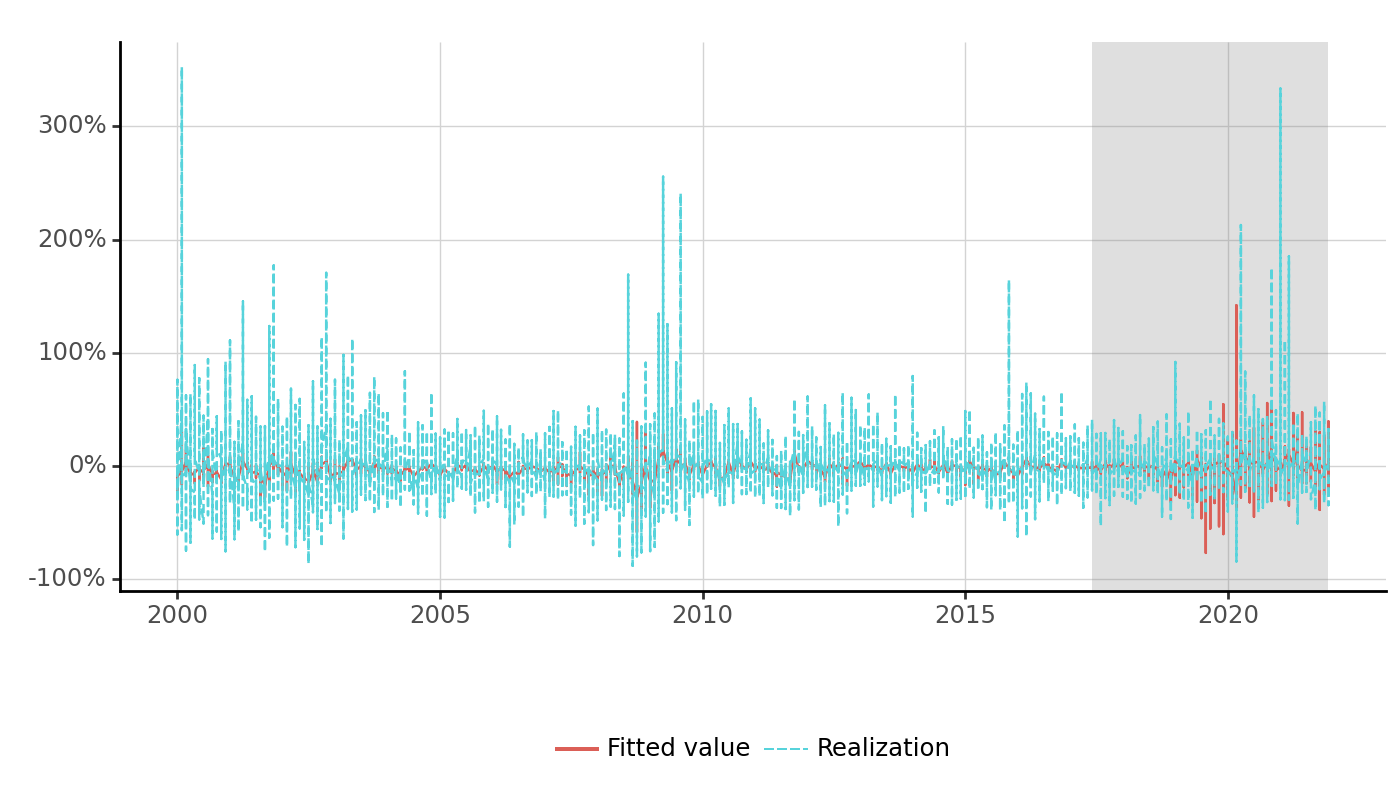

<Figure Size: (700 x 400)>

In [89]:
# Plotting
POLS = (
    ggplot(predicted_values, aes(x="month", y="return", color="Variable", linetype="Variable")) +
    annotate(
        "rect",
        xmin=data_training["month"].max(),
        xmax=data["month"].max(),
        ymin=-np.inf, ymax=np.inf,
        alpha=0.25, fill="#808080"
    ) +
    geom_line() +
    labs(x="", y="", color="", linetype="", title=f"") +
    theme_classic() + 
    theme(figure_size=(7, 4),
                    panel_grid_major=element_line(color="lightgray", size=0.5),
                    panel_grid_minor=element_blank(), 
        legend_position="bottom") +
    scale_x_datetime(breaks=date_breaks("5 years"), labels=date_format("%Y")) +
    scale_y_continuous(labels=percent_format())
)
POLS.save(filename=f'plots/predictions/predictions_POLS.png', format='png', verbose=False)
POLS

In [6]:
alphas = np.logspace(-1, 6, 100) 
# LASSO
Lasso = ElasticNet(fit_intercept=False, l1_ratio=1, max_iter=5000)

# Set up pipeline
lm_pipeline_Lasso = Pipeline([
    ("preprocessor", preprocessor),
    ("regressor", Lasso)
])
params = {"regressor__alpha": alphas}

finder_Lasso = GridSearchCV(
  lm_pipeline_Lasso,
  param_grid=params,
  scoring="neg_root_mean_squared_error",
  cv=5
)
# Fit the model to the entire panel data
start = time.time()
finder_Lasso.fit(
    data.drop(columns=["ret_excess"]), data["ret_excess"]
)
end = time.time()
print(f'{round(end - start,3)/60} minutes')
result_panel_Lasso = pd.DataFrame(finder_Lasso.best_estimator_.named_steps.regressor.coef_ != 0)
optimal_alpha_panel = finder_Lasso.best_params_['regressor__alpha']  # Extract optimal alpha
print("Lasso:", optimal_alpha_panel)

11.457116666666668 minutes
Lasso: 0.1


In [44]:
# Store optimal lasso alphas 
lasso_alpha_500 = 0.01
lasso_alpha_250 = 0.001542123
lasso_alpha_100 = 0.001
lasso_alpha_50 = 0.0012045035402587824


Out-of-sample R^2: 0.2071
MSPE: 0.0071


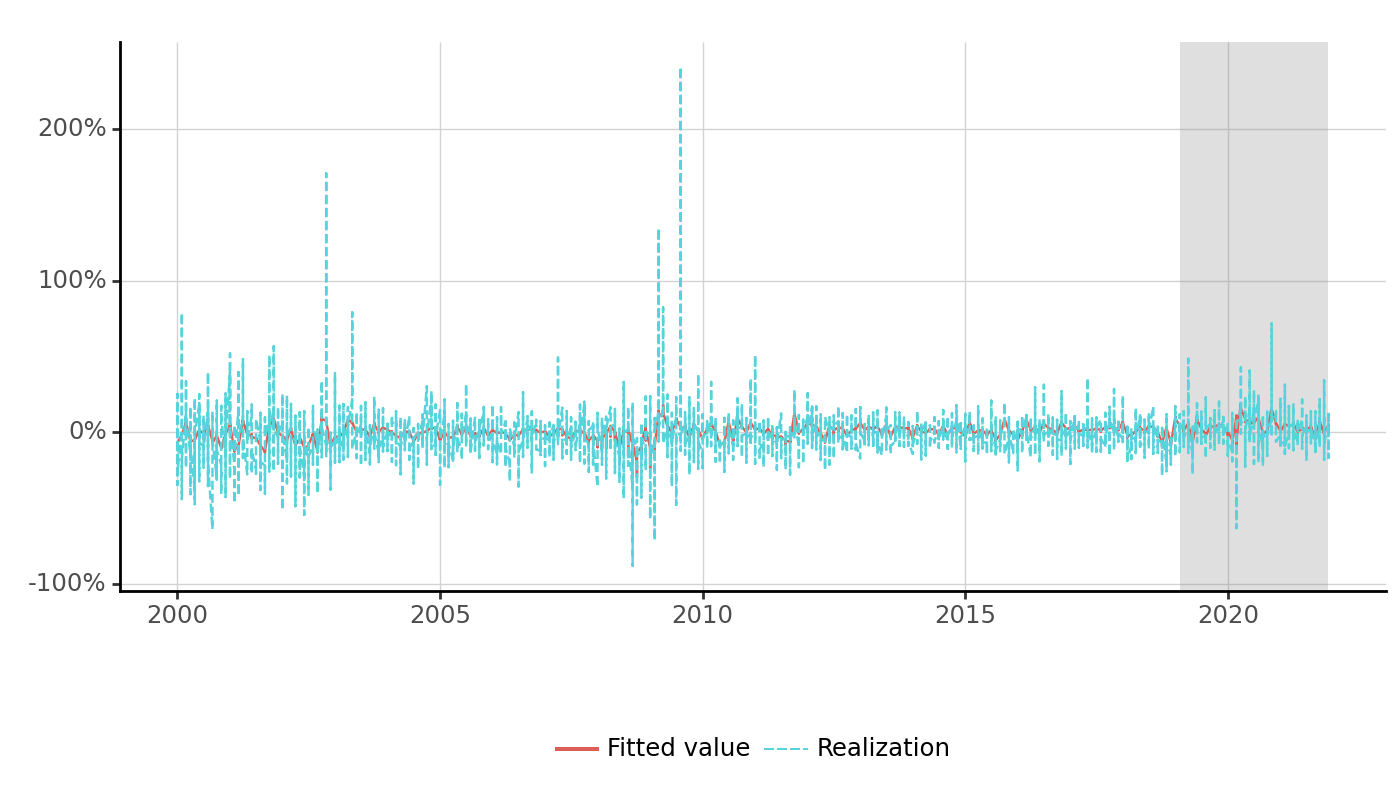

In [97]:
# Set up Lasso Net Model
lm_model = ElasticNet(
    alpha=lasso_alpha_50, # Strength of regularization (lambda penalty)
    l1_ratio=1, # Weight on Lasso vs Ridge (l1_ratio = 1, means 100 pct. Lasso)
    max_iter=5000, # Maximum number of iteration for optimization
    fit_intercept=False 
)  
    
lm_pipeline = Pipeline([
    ("preprocessor", preprocessor),
    ("regressor", lm_model)
])
print(pl.prediction_plot_panel(data, lm_pipeline))

### Ridge

In [9]:
alphas_ridge = np.logspace(-1, 6, 100) 
# RIDGE
ridge = Ridge(fit_intercept=False)

# Set up pipeline
lm_pipeline_Ridge = Pipeline([
    ("preprocessor", preprocessor),
    ("regressor", ridge)
])

# Set up grid search
params = {"regressor__alpha": alphas_ridge}

finder_Ridge = GridSearchCV(
  lm_pipeline_Ridge,
  param_grid=params,
  scoring="neg_mean_squared_error",
  cv=5
)
start = time.time()


# Fit the model to the entire panel data
finder_Ridge.fit(
    data.drop(columns=["ret_excess"], axis = 1), data["ret_excess"]
)
end = time.time()
print(f'{round(end - start,3)/60} minutes')

# Store results
result_panel_Ridge = pd.DataFrame(finder_Ridge.best_estimator_.named_steps.regressor.coef_ != 0)

optimal_alpha_panel_Ridge = finder_Ridge.best_params_['regressor__alpha']  # Extract optimal alpha
print("Ridge:", optimal_alpha_panel_Ridge)

11.2044 minutes
Ridge: 1747.5284000076829


In [24]:
# Store optimal ridge alphas 
RidgeALPHA_500 = 1747.5284000076829
RidgeALPHA_250 = 0.15034
RidgeALPHA_100 = 0.010045034503
RidgeALPHA_50 = 0.104503


Out-of-sample R^2: 0.2009
MSPE: 0.0071


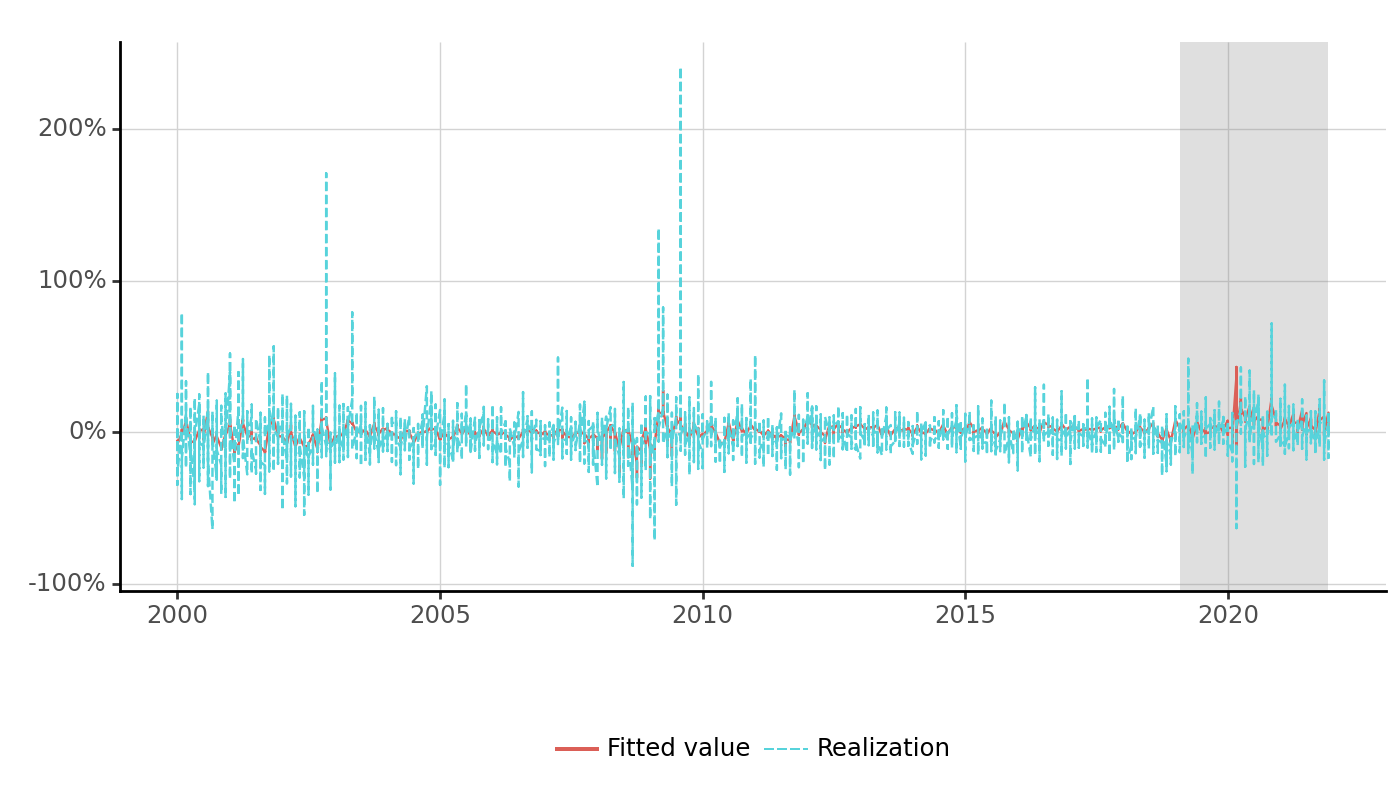

In [98]:
# Set up Ridge Model
lm_model = Ridge(
    alpha=RidgeALPHA_500, # Strength of regularization (lambda penalty)
    fit_intercept=False 
)  
    
lm_pipeline = Pipeline([
    ("preprocessor", preprocessor),
    ("regressor", lm_model)
])
print(pl.prediction_plot_panel(data, lm_pipeline))

### Elastic Net

In [12]:
# Elastic Net
EN = ElasticNet(fit_intercept=False, l1_ratio=0.5, max_iter=5000)

# Set up pipeline
lm_pipeline_EN = Pipeline([
    ("preprocessor", preprocessor),
    ("regressor", Lasso)
])
params = {"regressor__alpha": alphas}

finder_EN = GridSearchCV(
  lm_pipeline_EN,
  param_grid=params,
  scoring="neg_root_mean_squared_error",
  cv=5
)
# Fit the model to the entire panel data
start = time.time()
finder_EN.fit(
    data.drop(columns=["ret_excess"]), data["ret_excess"]
)
end = time.time()
print(f'{round(end - start,3)/60} minutes')
result_panel_EN = pd.DataFrame(finder_EN.best_estimator_.named_steps.regressor.coef_ != 0)
optimal_alpha_panel = finder_EN.best_params_['regressor__alpha']  # Extract optimal alpha
print("EN:", optimal_alpha_panel)

11.477966666666667 minutes
EN: 0.1


In [47]:
# Store optimal elastic net alphas 
en_alpha_500 = 0.5
en_alpha_250 = 0.001878235424
en_alpha_100 = 0.0014873548783844
en_alpha_50 = 0.0012045035402587824


Out-of-sample R^2: -0.0675
MSPE: 0.0095


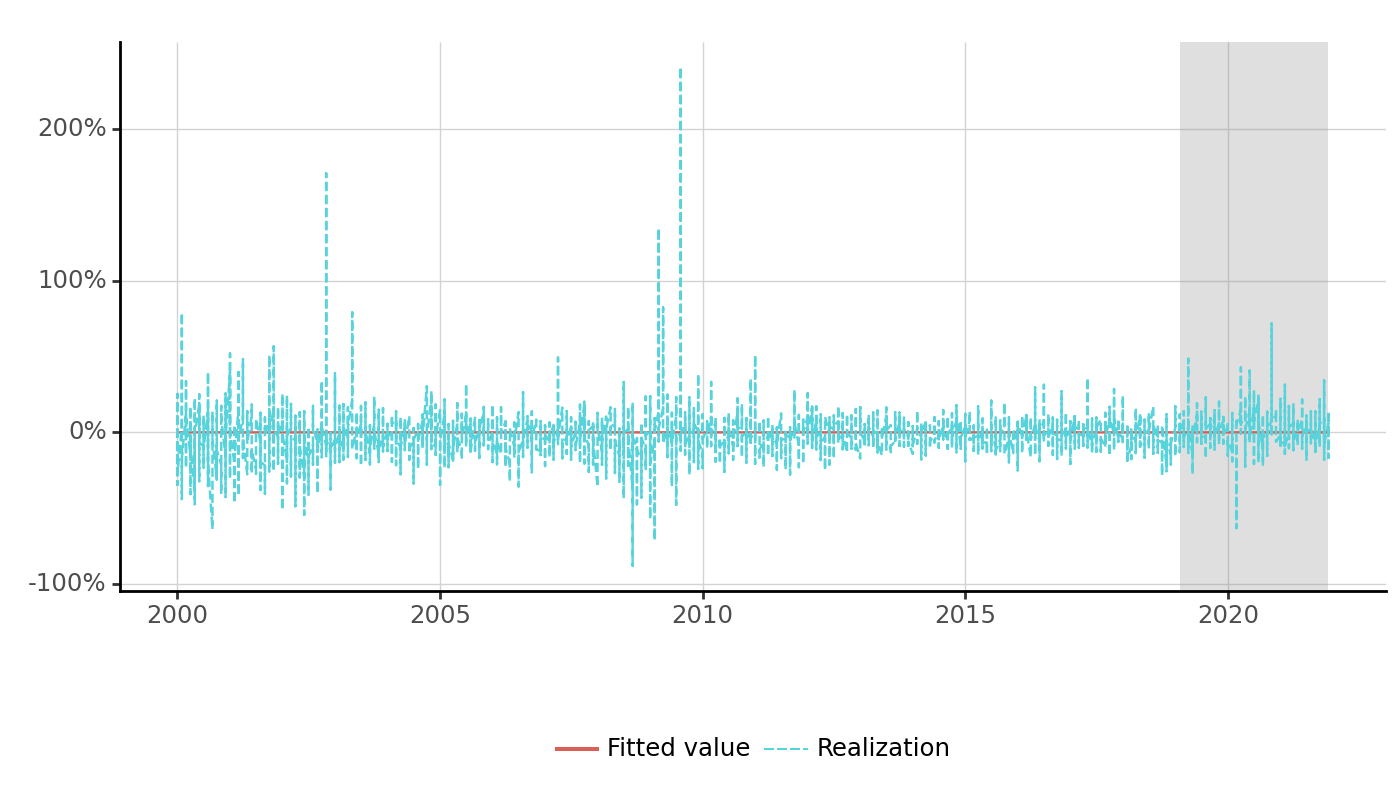

In [99]:
# Set up Elastic Net Model
lm_model = ElasticNet(
    alpha=en_alpha_500, # Strength of regularization (lambda penalty)
    l1_ratio=0.5, # Weight on Lasso vs Ridge (l1_ratio = 1, means 100 pct. Lasso)
    max_iter=5000, # Maximum number of iteration for optimization
    fit_intercept=False 
)  
    
lm_pipeline = Pipeline([
    ("preprocessor", preprocessor),
    ("regressor", lm_model)
])
print(pl.prediction_plot_panel(data, lm_pipeline))

### Selected Factors

In [32]:
def extract_selected_features(lm_pipeline, finder, data):
    # Fit the pipeline to the data
    lm_pipeline.fit(data.drop(columns=["ret_excess"]), data["ret_excess"])

    # Extract selected features based on the type of regression
    if 'lasso' in lm_pipeline.named_steps['regressor'].__class__.__name__.lower() or 'elasticnet' in lm_pipeline.named_steps['regressor'].__class__.__name__.lower():
        selected_features = pd.DataFrame(
            finder.best_estimator_.named_steps.regressor.coef_ != 0,
            index=lm_pipeline[:-1].named_steps.preprocessor.get_feature_names_out(),
            columns=["selected"]
        )
    elif 'ridge' in lm_pipeline.named_steps['regressor'].__class__.__name__.lower():
        selected_features = pd.DataFrame(
            finder.best_estimator_.named_steps.regressor.coef_ > 0.05,
            index=lm_pipeline[:-1].named_steps.preprocessor.get_feature_names_out(),
            columns=["selected"]
        )
    else:
        raise ValueError("Unsupported regression type. Supported types: Lasso, Elastic Net, Ridge")
    
    # Remove prefixes from variable names if necessary
    selected_features.index = selected_features.index.str.replace("factor_|ff_|q_|macro_", "")

    return selected_features.astype(bool)

factors_Lasso = extract_selected_features(lm_pipeline_Lasso, finder_Lasso, data)
factors_Ridge = extract_selected_features(lm_pipeline_Ridge, finder_Ridge, data)
factors_EN = extract_selected_features(lm_pipeline_EN, finder_EN, data)
selected_factors = pd.concat([factors_Lasso,factors_Ridge,factors_EN], axis = 1)
selected_factors.reset_index(inplace=True)
selected_factors.columns = ['Factor', 'Lasso','Ridge','Elastic Net'] 
melted_factors = pd.melt(selected_factors, id_vars='Factor', var_name='Estimator', value_name='Selected')
melted_factors = melted_factors[melted_factors['Selected']]

In [33]:
plot_selection = (ggplot(melted_factors,
        aes(x='Estimator', y='Factor', fill='Estimator')) +
 geom_tile() +
 labs(x="", y="", title="") +
 scale_x_discrete(limits=reversed) + 
 scale_fill_manual(values=["deepskyblue", "red", "violet"], guide = False) +
 theme(axis_text_x=element_text(rotation=70, hjust=1, size = 8), axis_text_y = element_text(size=6),
       figure_size=(6, 7)))
plot_selection.save(filename='plots/selected_factors.png', format='png', verbose=False)

plot_selection

TypeError: 'NoneType' object is not reversible